In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D,Dense,InputLayer,Flatten,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError,Huber,MeanAbsoluteError,BinaryCrossentropy

In [2]:
dataset,dataset_info = tfds.load('malaria',with_info=True,as_supervised=True,shuffle_files=True,split=['train'])

In [3]:
TRAIN_RATIO = 0.8
TEST_RATIO = 0.1
VAL_RATIO = 0.1

In [4]:
def split(dataset,TRAIN_RATIO,TEST_RATIO,VAL_RATIO):

  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))


  val_dataset = val_test_dataset.take(int(VAL_RATIO * DATASET_SIZE))


  test_dataset = val_test_dataset.skip(int(VAL_RATIO * DATASET_SIZE))

  return train_dataset,test_dataset,val_dataset




In [5]:
train_dataset,test_dataset,val_dataset = split(dataset[0],TRAIN_RATIO,TEST_RATIO,VAL_RATIO)
print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)]
[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

Data Visualization

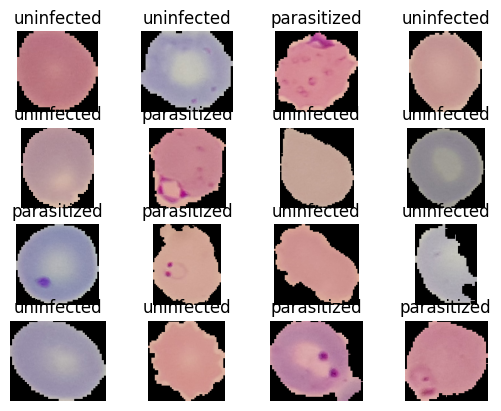

In [6]:
for i,(image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4,i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [7]:
dataset_info.features['label'].int2str(0)

'parasitized'

Data Preprocessing


In [8]:
IM_SIZE = 224
def resize_rescale(image,label):
  return tf.image.resize(image,(IM_SIZE,IM_SIZE))/255.0,label

In [9]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [10]:
for image,label in train_dataset.take(1):
  print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [11]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True,).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [12]:

val_dataset = val_dataset.shuffle(buffer_size=8,reshuffle_each_iteration=True,).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [14]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [15]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE,IM_SIZE,3)),
    Conv2D(filters = 6, kernel_size = 3, strides=1,padding='valid',activation='relu'),
     BatchNormalization(),
    MaxPool2D(pool_size=2,strides=1),



    Conv2D(filters = 16, kernel_size = 5, strides=1,padding='valid',activation='relu'),
     BatchNormalization(),
    MaxPool2D(pool_size=2,strides=2),
    Flatten(),
    Dense(100, activation = "relu"),
    Dense(10, activation = "relu"),
    Dense(1, activation = "sigmoid"),

])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 221, 221, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 217, 217, 16)      2416      
                                                                 
 batch_normalization_1 (Bat  (None, 217, 217, 16)      64        
 chNormalization)                                                
                                                        

In [16]:
model.compile(optimizer=Adam(learning_rate=0.1),
              loss = BinaryCrossentropy(),
              metrics = ['accuracy'])


In [ ]:
history = model.fit(train_dataset, validation_data = val_dataset,epochs = 20, verbose=1)

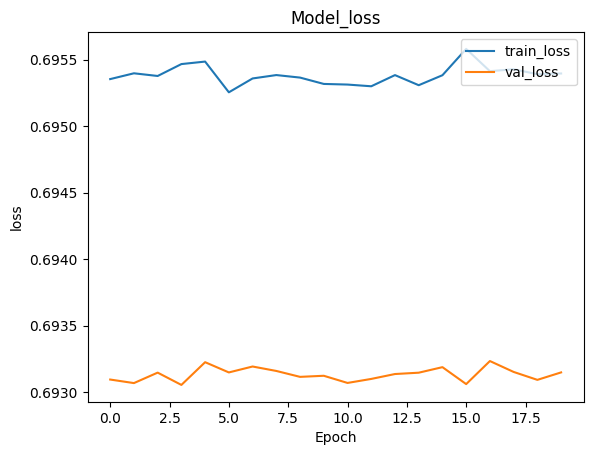

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['train_loss','val_loss'],loc='upper right')
plt.show()

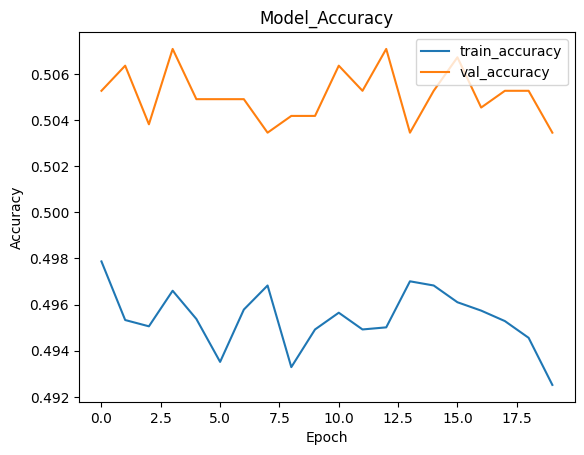

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy','val_accuracy'],loc='upper right')
plt.show()

Model Evaluation and Testing

In [ ]:
test_dataset = test_dataset.batch(1)

In [ ]:
model.evaluate(test_dataset)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.5056 - loss: 0.6931


[0.6933866143226624, 0.49474066495895386]

In [ ]:
def parasite_or_not(x):
  if(x<0.5):
    return str("P")
  else:
    return str("U")

In [ ]:
parasite_or_not(model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


'U'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


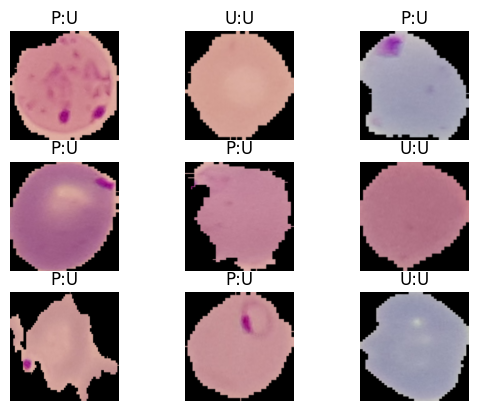

In [ ]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
  plt.axis('off')

In [25]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input


In [38]:
func_input = Input(shape=(IM_SIZE,IM_SIZE,3),name = 'Input Image')

x = Conv2D(filters = 6, kernel_size = 3, strides=1,padding='valid',activation='relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=1)(x)

x = Conv2D(filters = 16, kernel_size = 5, strides=1,padding='valid',activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=2,strides=2)(x)


output = Dense(1, activation = "sigmoid")(x)


feature_extractor_model = Model(func_input,output,name = "feature_extractor")

feature_extractor_model.summary()



Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_16 (Ba  (None, 222, 222, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 221, 221, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 217, 217, 16)      2416      
                                                                 
 batch_normalization_17 (Ba  (None, 217, 217, 16)

In [39]:
func_input = Input(shape=(IM_SIZE,IM_SIZE,3),name = 'Input Image')

x = feature_extractor_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)


lenet_model_func = Model(func_input,func_output, name = 'Lenet Model')

lenet_model_func.summary()



Model: "Lenet Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 feature_extractor (Functio  (None, 108, 108, 1)       2689      
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 11664)             0         
                                                                 
 dense_16 (Dense)            (None, 100)               1166500   
                                                                 
 batch_normalization_18 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_17 (Dense)            (None, 10)                

In [30]:
lenet_model_func.compile(optimizer=Adam(learning_rate=0.1),
              loss = BinaryCrossentropy(),
              metrics = ['accuracy'])


In [ ]:
history = model.fit(train_dataset, validation_data = val_dataset,epochs = 20, verbose=1)